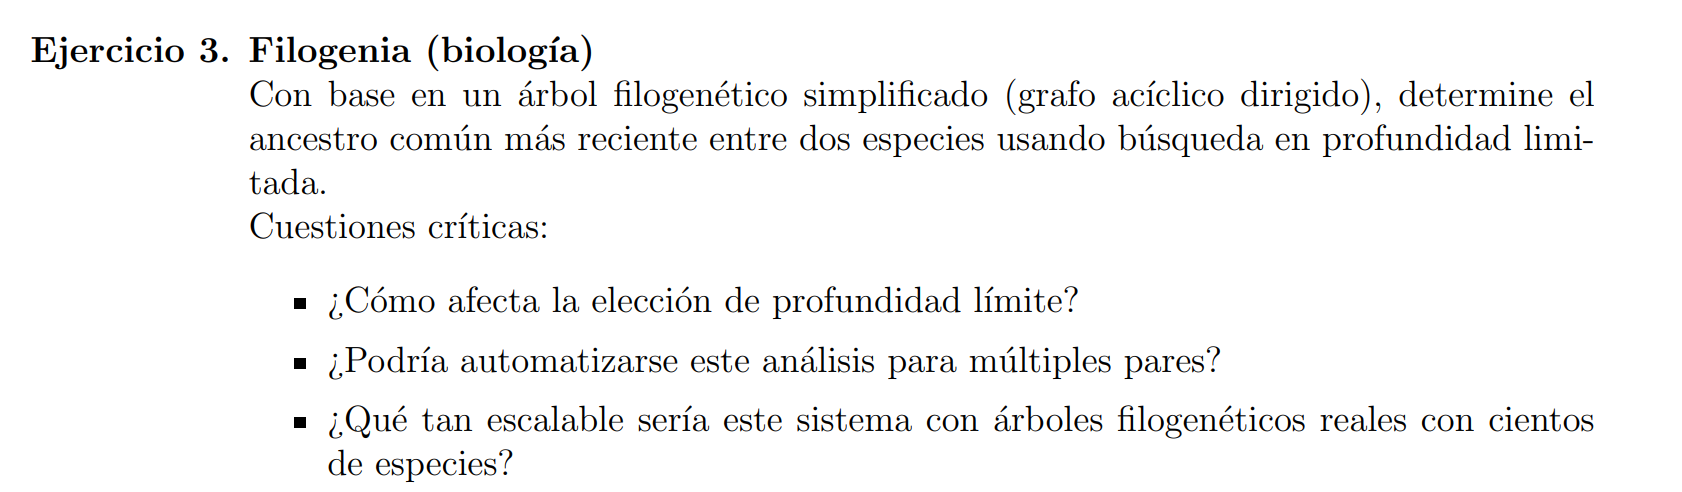

**What's a DAG?** an acyclic directed graph (often called a Directed Acyclic Graph or DAG) is a graph that: Has directed edges (arrows go from one node to another in a specific direction) Does not contain any cycles (there is no way to start at a node and follow a sequence of edges that eventually loops back to the starting node)


In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import random

 **EJEMPLOS DE UN DAG**

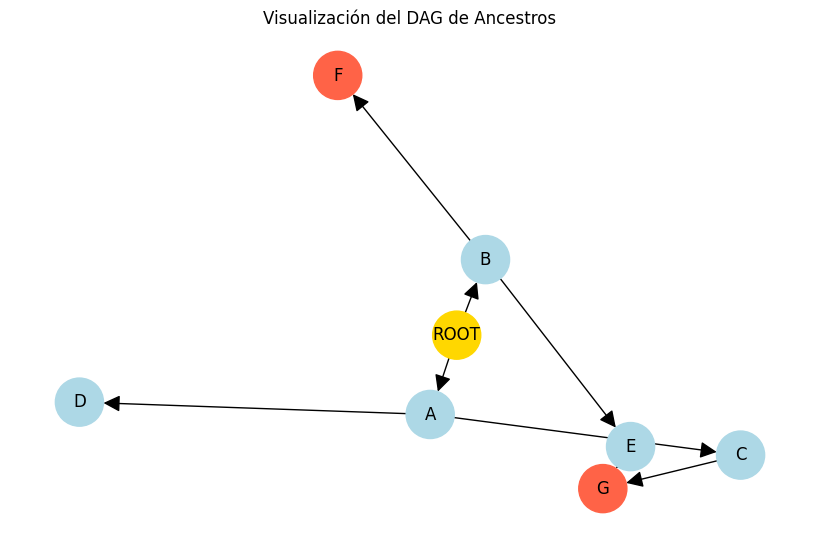

In [10]:
# Definir el grafo de padres como antes
parents = {
    'C': ['A'],
    'D': ['A'],
    'E': ['B'],
    'F': ['B'],
    'A': ['ROOT'],
    'B': ['ROOT'],
    'G': ['C', 'E']
}

# Construir el grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas (de padres a hijos)
for child, parent_list in parents.items():
    for parent in parent_list:
        G.add_edge(parent, child)

# Opcional: puedes resaltar los nodos de interés
nodos_destacados = ['G', 'F']

# Definir colores para resaltar
node_colors = []
for node in G.nodes:
    if node in nodos_destacados:
        node_colors.append('tomato')
    elif node == 'ROOT':
        node_colors.append('gold')
    else:
        node_colors.append('lightblue')

# Dibujar el grafo
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G, seed=42)  # Puedes cambiar a nx.shell_layout(G) si prefieres

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1200, arrowsize=25)
plt.title("Visualización del DAG de Ancestros")
plt.show()


► MRCA entre 'C' y 'D': A


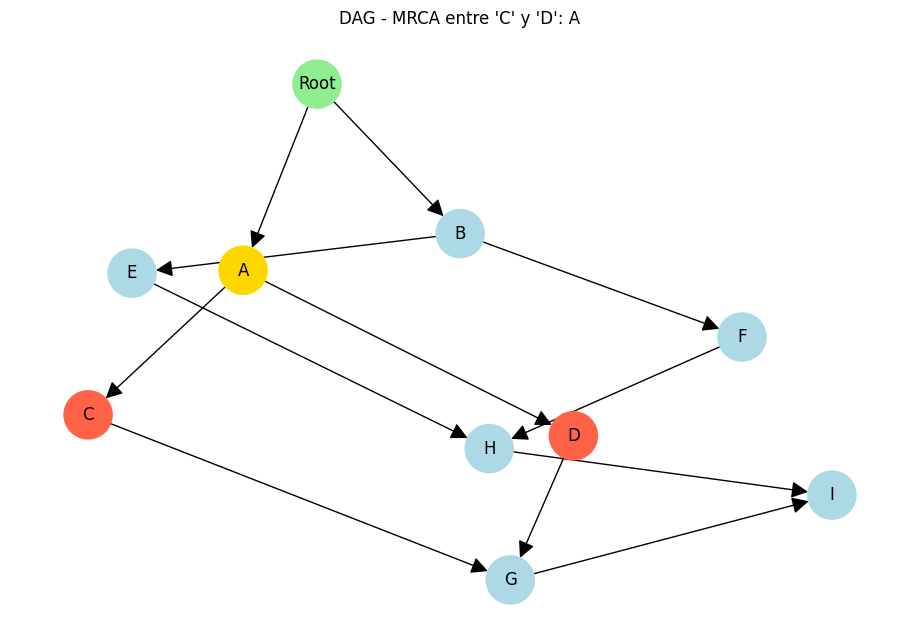

► MRCA entre 'G' y 'H': Root


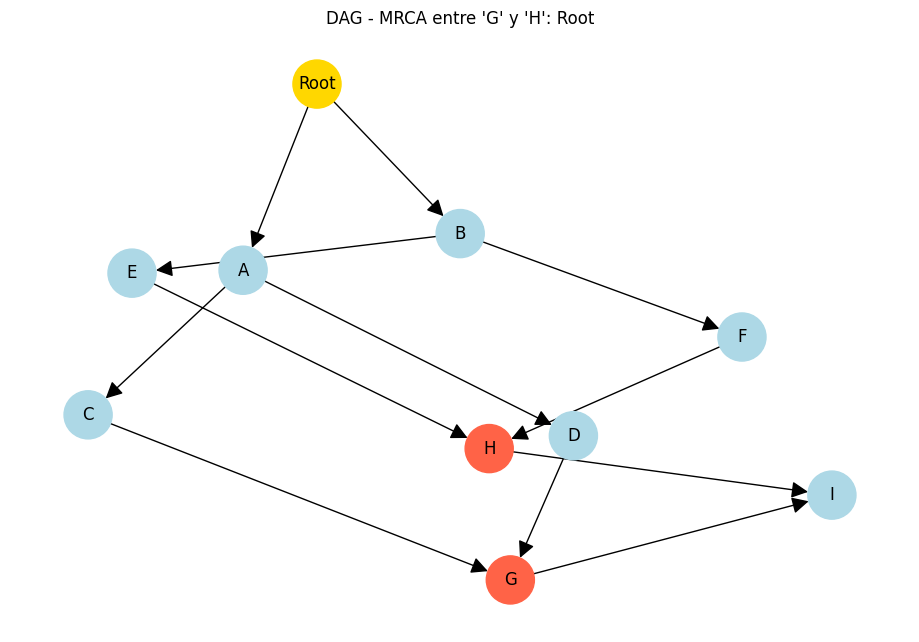

► MRCA entre 'I' y 'D': A


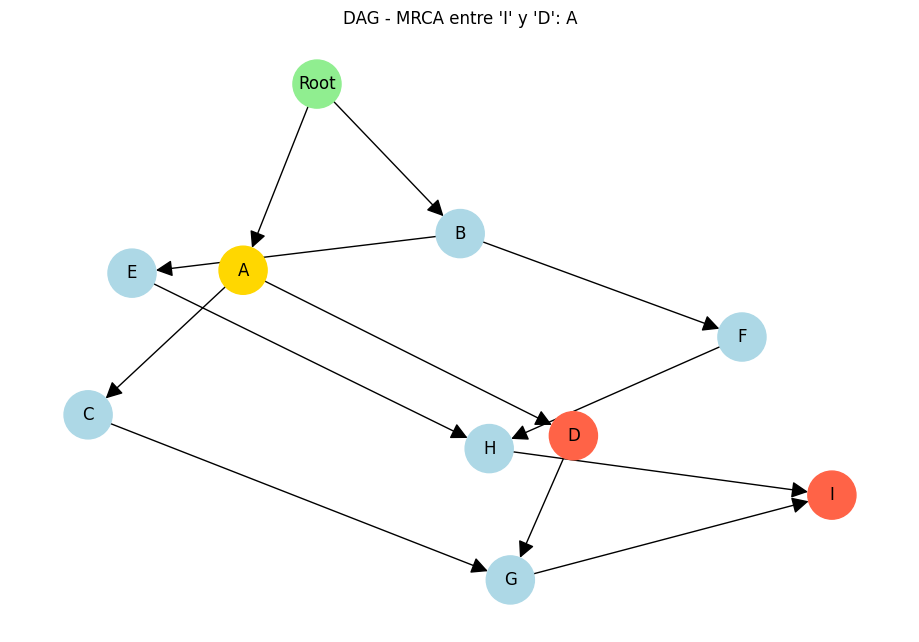

► MRCA entre 'E' y 'F': B


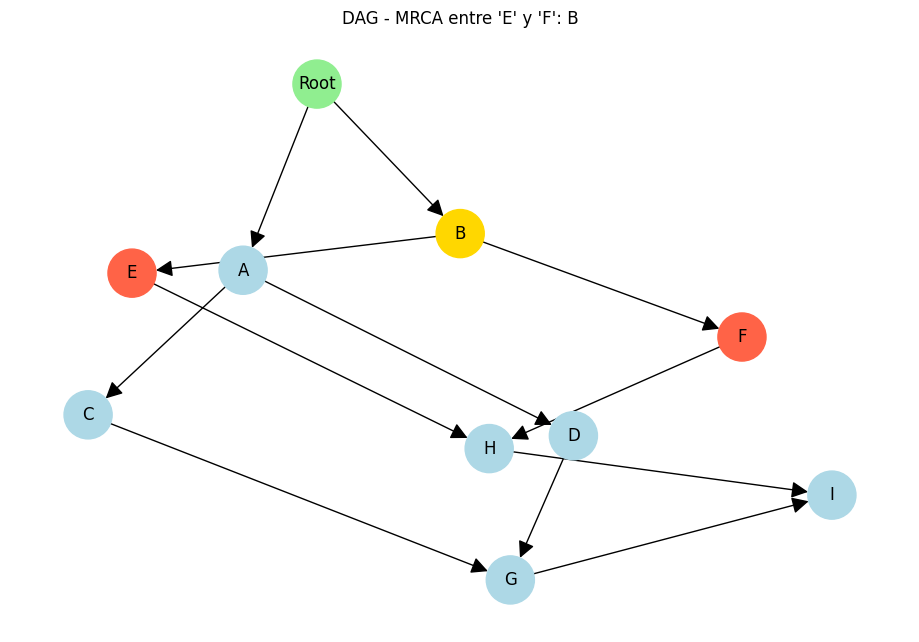

► MRCA entre 'I' y 'E': B


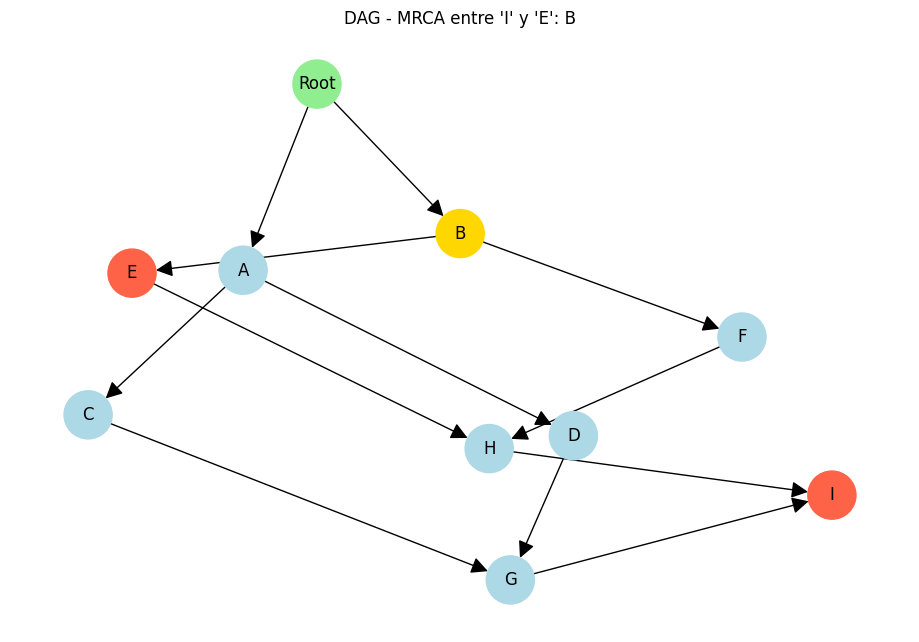

In [11]:

# Definimos el DAG
parents = {
    'A': ['Root'],
    'B': ['Root'],
    'C': ['A'],
    'D': ['A'],
    'E': ['B'],
    'F': ['B'],
    'G': ['C', 'D'],
    'H': ['E', 'F'],
    'I': ['G', 'H']
}

# Función para encontrar ancestros con DLS
def dls_ancestors(node, parents, limit):
    ancestors = {}
    stack = [(node, 0)]
    while stack:
        curr, depth = stack.pop()
        if depth > limit:
            continue
        if curr in parents:
            for p in parents[curr]:
                if p not in ancestors or depth+1 < ancestors[p]:
                    ancestors[p] = depth+1
                    stack.append((p, depth+1))
    return ancestors

# Función para visualizar el DAG con colores personalizados
def visualizar_dag(parents, especie1, especie2, mrca):
    G = nx.DiGraph()
    for child, parent_list in parents.items():
        for parent in parent_list:
            G.add_edge(parent, child)

    node_colors = []
    for node in G.nodes:
        if node == especie1 or node == especie2:
            node_colors.append('tomato')    # Las dos especies consultadas (rojo)
        elif node == mrca and mrca is not None:
            node_colors.append('gold')      # El MRCA (dorado)
        elif node == 'Root':
            node_colors.append('lightgreen') # Raíz
        else:
            node_colors.append('lightblue') # Otros

    plt.figure(figsize=(9, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1200, arrowsize=25)
    plt.title(f"DAG - MRCA entre '{especie1}' y '{especie2}': {mrca}")
    plt.show()

# ---- JUEGO DE PREGUNTAS ----

# Elije dos nodos, por ejemplo:
pares = [('C', 'D'), ('G', 'H'), ('I', 'D'), ('E', 'F'), ('I', 'E')]

MAX_DEPTH = 10

for especie1, especie2 in pares:
    ancestros_1 = dls_ancestors(especie1, parents, MAX_DEPTH)
    ancestros_2 = dls_ancestors(especie2, parents, MAX_DEPTH)
    comunes = set(ancestros_1.keys()).intersection(ancestros_2.keys())
    if comunes:
        mrca = min(comunes, key=lambda x: ancestros_1[x] + ancestros_2[x])
    else:
        mrca = None
    print(f"► MRCA entre '{especie1}' y '{especie2}': {mrca}")
    visualizar_dag(parents, especie1, especie2, mrca)


***INTERACTIVO***

In [12]:
import tkinter as tk
from tkinter import messagebox, simpledialog
import random
from collections import defaultdict, deque

# ------------------------------
# DAG + MRCA utility functions
# ------------------------------

def generate_random_dag(n: int, p: float = 0.18, ensure_connected: bool = True):
    """
    Generate a random DAG with nodes 0..n-1 (topological order by index).
    - If ensure_connected=True, build a spanning 'backbone' from 0 so every node is reachable:
      for each j>0 pick a random i<j and add edge i->j (guarantees acyclicity since i<j).
    - Then add extra forward edges i->j (i<j) independently with probability p.
    Returns:
      parents: dict[int, set[int]] mapping node -> set of parent nodes
      children: dict[int, set[int]] mapping node -> set of child nodes
    """
    children = {i: set() for i in range(n)}
    parents = {i: set() for i in range(n)}

    # Backbone to ensure reachability from root 0 (arborescence-like)
    if ensure_connected:
        for j in range(1, n):
            i = random.randrange(0, j)  # choose a predecessor i < j
            children[i].add(j)
            parents[j].add(i)

    # Extra random forward edges, still i < j to keep it acyclic
    for i in range(n):
        for j in range(i + 1, n):
            if j not in children[i]:
                if random.random() < p:
                    children[i].add(j)
                    parents[j].add(i)

    return parents, children


def topo_order(parents, children):
    """
    Kahn's algorithm for topological sort.
    Uses current indegrees; raises if a cycle is detected (shouldn't happen here).
    """
    n = len(children)
    indeg = [len(parents[i]) for i in range(n)]
    q = deque([i for i in range(n) if indeg[i] == 0])
    order = []
    while q:
        u = q.popleft()
        order.append(u)
        for v in children[u]:
            indeg[v] -= 1
            if indeg[v] == 0:
                q.append(v)
    if len(order) != n:
        raise ValueError("Graph is not acyclic (should not happen with forward edges only)")
    return order


def compute_depths(parents, order):
    """
    Compute longest-path depth from source(s) in a DAG:
      depth[u] = 0 if no parents; otherwise 1 + max(depth[parent]).
    """
    depth = {u: 0 for u in order}
    for u in order:
        if parents[u]:
            depth[u] = max(depth[p] for p in parents[u]) + 1
    return depth


def ancestors_of(node, parents):
    """
    Collect all ancestors of 'node' (including node itself) by walking up parent links.
    """
    seen = set()
    stack = [node]
    while stack:
        u = stack.pop()
        if u in seen:
            continue
        seen.add(u)
        for p in parents[u]:
            stack.append(p)
    return seen


def mrca_of_set(nodes, parents, depth):
    """
    MRCA (Most Recent Common Ancestor) of a set of nodes in a DAG:
    - Intersect ancestor sets of all nodes.
    - From the intersection, choose the one with maximal depth (the 'most recent').
    Returns None if there is no common ancestor.
    """
    if not nodes:
        return None
    iter_nodes = iter(nodes)
    common = ancestors_of(next(iter_nodes), parents)
    for u in iter_nodes:
        common &= ancestors_of(u, parents)
        if not common:
            return None
    return max(common, key=lambda x: depth[x]) if common else None


def one_up_path_to_ancestor(u, a, parents):
    """
    Find ONE path from node u up to ancestor a by BFS over parent links.
    Returns a list [a, ..., u] (ancestor-to-descendant order) if found; [] otherwise.
    """
    if a == u:
        return [a]
    from collections import deque as _dq
    q = _dq([u])
    prev = {u: None}  # prev[x] = child we came from while moving upwards (parents)
    while q:
        x = q.popleft()
        if x == a:
            break
        for p in parents[x]:
            if p not in prev:
                prev[p] = x
                q.append(p)
    if a not in prev and a != u:
        return []
    # Reconstruct path by walking from a down to u using 'prev' pointers
    path = [a]
    cur = a
    while prev.get(cur) is not None:
        cur = prev[cur]
        path.append(cur)
    return path  # a -> ... -> u

# ------------------------------
# UI: Tkinter mini-game
# ------------------------------

NODE_RADIUS = 18
WIDTH, HEIGHT = 980, 640
PADDING_X, PADDING_Y = 80, 60
ROW_GAP = 100

class DAGGame:
    """
    Small Tkinter app to:
    - Generate a random DAG
    - Let the user select ≥2 nodes
    - Compute and highlight their MRCA and the paths from each selection up to it
    """
    def __init__(self, root):
        self.root = root
        self.root.title("DAG MRCA Mini-Game")

        # --- Top control bar ---
        top = tk.Frame(root)
        top.pack(side=tk.TOP, fill=tk.X)

        self.info_var = tk.StringVar(
            value="Select ≥2 nodes, press 'Find MRCA' 🧬. Paths will be highlighted."
        )
        tk.Label(top, textvariable=self.info_var, font=("Segoe UI", 11)).pack(
            side=tk.LEFT, padx=10, pady=8
        )

        tk.Button(top, text="Find MRCA", command=self.find_mrca, font=("Segoe UI", 10, "bold")).pack(side=tk.RIGHT, padx=6)
        tk.Button(top, text="Clear", command=self.clear_selection).pack(side=tk.RIGHT, padx=6)
        tk.Button(top, text="Regenerate", command=self.regenerate).pack(side=tk.RIGHT, padx=6)

        # --- Canvas for graph ---
        self.canvas = tk.Canvas(root, width=WIDTH, height=HEIGHT, bg="#fcfcfe", highlightthickness=0)
        self.canvas.pack(fill=tk.BOTH, expand=True)

        # Mouse click selects/deselects nodes
        self.canvas.bind("<Button-1>", self.on_click)

        # Keyboard shortcuts: m=find MRCA, r=regenerate, c=clear
        root.bind("m", lambda e: self.find_mrca())
        root.bind("r", lambda e: self.regenerate())
        root.bind("c", lambda e: self.clear_selection())

        # Ask user for node count on startup (defaults to 12 if canceled)
        self.n = simpledialog.askinteger("Nodes", "How many nodes? (3–40)", minvalue=3, maxvalue=40, initialvalue=12)
        if not self.n:
            self.n = 12

        self.random_seed = None  # set to an integer for reproducible DAGs

        # Graph/model state
        self.parents = {}
        self.children = {}
        self.depth = {}
        self.order = []

        # Rendering state
        self.node_positions = {}  # node -> (x, y) on canvas
        self.node_items = {}      # node -> (circle_id, text_id)
        self.edge_items = {}      # (u, v) -> line_id

        # Interaction state
        self.selected = []        # list of selected nodes (order preserved)
        self.mrca_node = None
        self.highlighted_edges = set()
        self.highlighted_nodes = set()

        # Build DAG and draw
        self.build_and_draw()

    # ---------------- Graph build & layout ----------------
    def build_and_draw(self):
        """Generate a new DAG, compute order/depth, layout nodes, and draw everything."""
        if self.random_seed is not None:
            random.seed(self.random_seed)

        self.parents, self.children = generate_random_dag(self.n, p=0.22, ensure_connected=True)
        self.order = topo_order(self.parents, self.children)
        self.depth = compute_depths(self.parents, self.order)
        self.layout_nodes()
        self.draw_graph()
        self.update_status()

    def layout_nodes(self):
        """
        Place nodes in horizontal rows by depth (0 at top).
        Within each row, spread nodes evenly across the canvas width.
        """
        by_depth = defaultdict(list)
        for u in self.order:
            by_depth[self.depth[u]].append(u)
        max_depth = max(by_depth.keys())

        self.node_positions = {}

        # Vertical spacing to fit rows neatly within canvas height
        row_gap = min(ROW_GAP, max(70, (HEIGHT - 2 * PADDING_Y) // max(1, (max_depth + 1))))
        y0 = PADDING_Y

        for d in range(max_depth + 1):
            row = by_depth[d]
            if not row:
                continue
            y = y0 + d * row_gap

            # Horizontal coordinates for nodes in this row
            count = len(row)
            if count == 1:
                xs = [WIDTH // 2]
            else:
                span = WIDTH - 2 * PADDING_X
                xs = [int(PADDING_X + i * (span / (count - 1))) for i in range(count)]

            # Initialize positions; then assign deterministically by sorted node id
            for u in row:
                self.node_positions[u] = None
            row_sorted = sorted(row)
            for u, x in zip(row_sorted, xs):
                self.node_positions[u] = (x, y)

    # ---------------- Drawing ----------------
    def draw_graph(self):
        """Clear canvas and draw edges and nodes with current layout."""
        self.canvas.delete("all")
        self.edge_items.clear()

        # Draw edges first so nodes render on top
        for u in range(self.n):
            x1, y1 = self.node_positions[u]
            for v in self.children[u]:
                x2, y2 = self.node_positions[v]
                line_id = self.draw_arrow(x1, y1, x2, y2)
                self.edge_items[(u, v)] = line_id

        # Draw nodes (root tinted slightly)
        self.node_items.clear()
        for u in range(self.n):
            x, y = self.node_positions[u]
            fill = "#ffffff" if u != 0 else "#e9f5ff"  # special tint for root 0
            circle = self.canvas.create_oval(
                x - NODE_RADIUS, y - NODE_RADIUS,
                x + NODE_RADIUS, y + NODE_RADIUS,
                fill=fill, outline="#2c3e50", width=2
            )
            label = self.canvas.create_text(x, y, text=str(u), font=("Segoe UI", 11, "bold"))
            self.node_items[u] = (circle, label)

    def draw_arrow(self, x1, y1, x2, y2):
        """
        Draw a straight arrow from node u to v, shortened so it touches the circles' borders.
        """
        import math
        dx, dy = x2 - x1, y2 - y1
        dist = max(1, math.hypot(dx, dy))
        ux, uy = dx / dist, dy / dist
        # Shift endpoints inward by NODE_RADIUS so the line meets circle borders nicely
        ax1 = x1 + ux * NODE_RADIUS
        ay1 = y1 + uy * NODE_RADIUS
        ax2 = x2 - ux * NODE_RADIUS
        ay2 = y2 - uy * NODE_RADIUS
        return self.canvas.create_line(ax1, ay1, ax2, ay2, arrow=tk.LAST, width=2, smooth=True)

    # ---------------- Interaction ----------------
    def on_click(self, event):
        """Canvas click handler: toggle selection if a node was clicked."""
        u = self.pick_node(event.x, event.y)
        if u is None:
            return
        self.toggle_select(u)

    def pick_node(self, x, y):
        """Return node id if (x,y) lies inside a node's circle; else None."""
        for u, (cx, cy) in self.node_positions.items():
            if (x - cx) ** 2 + (y - cy) ** 2 <= NODE_RADIUS ** 2:
                return u
        return None

    def toggle_select(self, u):
        """Add/remove a node from the selection and reset highlights."""
        if u in self.selected:
            self.selected.remove(u)
        else:
            self.selected.append(u)
        self.mrca_node = None
        self.highlighted_edges.clear()
        self.highlighted_nodes.clear()
        self.redraw_selection()
        self.update_status()

    def redraw_selection(self):
        """Refresh node/edge styling based on current selection and highlights."""
        # Reset all nodes
        for u, (circle, _) in self.node_items.items():
            outline = "#2c3e50"
            width = 2
            fill = "#e9f5ff" if u == 0 else "#ffffff"
            self.canvas.itemconfigure(circle, outline=outline, width=width, fill=fill)

        # Reset all edges
        for (u, v), line_id in self.edge_items.items():
            self.canvas.itemconfigure(line_id, width=2, fill="#000000")

        # Highlight selected nodes (blue outline)
        sel_color = "#2563eb"
        for u in self.selected:
            circle, _ = self.node_items[u]
            self.canvas.itemconfigure(circle, outline=sel_color, width=4)

        # Highlight MRCA node (gold fill)
        if self.mrca_node is not None:
            circle, _ = self.node_items[self.mrca_node]
            self.canvas.itemconfigure(circle, fill="#fde68a", outline="#b45309", width=3)

        # Highlight paths (edges green + nodes green outline)
        for (u, v) in self.highlighted_edges:
            if (u, v) in self.edge_items:
                self.canvas.itemconfigure(self.edge_items[(u, v)], width=4, fill="#16a34a")
        for u in self.highlighted_nodes:
            if u in self.node_items:
                circle, _ = self.node_items[u]
                self.canvas.itemconfigure(circle, outline="#16a34a", width=4)

    def clear_selection(self):
        """Clear selection and all highlights."""
        self.selected.clear()
        self.mrca_node = None
        self.highlighted_edges.clear()
        self.highlighted_nodes.clear()
        self.redraw_selection()
        self.update_status()

    def find_mrca(self):
        """
        Compute MRCA of selected nodes and highlight:
        - The MRCA node itself
        - One upward path from each selected node to the MRCA
        """
        if len(self.selected) < 2:
            messagebox.showinfo("Pick nodes", "Select two or more nodes first.")
            return

        a = mrca_of_set(self.selected, self.parents, self.depth)
        self.mrca_node = a
        self.highlighted_edges.clear()
        self.highlighted_nodes.clear()

        if a is None:
            self.info_var.set(f"No common ancestor among {self.selected}.")
            self.redraw_selection()
            return

        # For each selected node, find a path up to MRCA and mark it
        for u in self.selected:
            path = one_up_path_to_ancestor(u, a, self.parents)  # returns a->...->u
            if not path:
                continue
            self.highlighted_nodes.update(path)
            # Convert a->...->u into forward edges (parent->child) to match drawn edges
            for i in range(len(path) - 1):
                p = path[i]
                c = path[i + 1]
                if (p, c) in self.edge_items:
                    self.highlighted_edges.add((p, c))

        self.info_var.set(f"MRCA of {self.selected} = {a} (depth {self.depth[a]}). Paths highlighted.")
        self.redraw_selection()

    def regenerate(self):
        """
        Build a fresh random DAG (optionally with a new node count) and redraw.
        """
        answer = messagebox.askyesno("Regenerate", "Do you want to change the node count?")
        if answer:
            n_new = simpledialog.askinteger("Nodes", "How many nodes? (3–40)",
                                            minvalue=3, maxvalue=40, initialvalue=self.n)
            if n_new:
                self.n = n_new
        self.clear_selection()
        self.build_and_draw()

    def update_status(self):
        """
        Update the instruction/status label based on current selection size.
        """
        k = len(self.selected)
        if k == 0:
            self.info_var.set("Select ≥2 nodes, then press 'Find MRCA' (or 'm').")
        elif k == 1:
            self.info_var.set(f"Selected: {self.selected[0]}. Select at least one more.")
        else:
            self.info_var.set(f"Selected: {self.selected}. Press 'Find MRCA'.")


if __name__ == "__main__":
    # Create and run the Tkinter app
    root = tk.Tk()
    app = DAGGame(root)
    root.mainloop()
